# Keras liner regression
Fit values from smog sensor without dryer to dryer version

### Imports

In [3]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam

### Config GPU

In [4]:
print(f'Keras version: {keras.__version__}')

gpu_info = tf.config.list_physical_devices("GPU")
print(f'Num GPUs: {len(gpu_info)}')

if len(gpu_info) > 0:
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.log_device_placement = True

    gpus = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)

Keras version: 2.7.0
Num GPUs: 1


# Read and show data

In [5]:
dataset = pd.concat([
    pd.read_csv('../dataset/smog_part1.csv', index_col = 0),
    pd.read_csv('../dataset/smog_part2_manual_fit.csv', index_col = 0)
])

dataset = dataset[dataset['humiditySht'] >= 60]

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29726 entries, 0 to 13412
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              29726 non-null  int64  
 1   date               29726 non-null  object 
 2   pm25_x             29726 non-null  float64
 3   pm10_x             29726 non-null  float64
 4   pressure           29726 non-null  int64  
 5   temperatureHeca_x  29726 non-null  float64
 6   humidityHeca_x     29726 non-null  int64  
 7   pm25_y             29726 non-null  float64
 8   pm10_y             29726 non-null  float64
 9   temperatureSht     29726 non-null  float64
 10  humiditySht        29726 non-null  int64  
 11  temperatureHeca_y  29726 non-null  float64
 12  humidityHeca_y     29726 non-null  int64  
 13  pm25_ratio         29726 non-null  float64
 14  pm10_ratio         29726 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 3.6+ MB


In [7]:
dataset.describe()

,index,pm25_x,pm10_x,pressure,temperatureHeca_x,humidityHeca_x,pm25_y,pm10_y,temperatureSht,humiditySht,temperatureHeca_y,humidityHeca_y,pm25_ratio,pm10_ratio
count,29726.000000,29726.000000,29726.000000,29726.000000,29726.000000,29726.000000,29726.000000,29726.000000,29726.000000,29726.000000,29726.000000,29726.000000,29726.000000,29726.000000
mean,12007.792471,9.771335,19.256718,990.509958,16.028443,57.345186,12.841698,23.583772,12.365626,76.459362,13.180539,70.159692,1.289290,1.194435
std,7844.857803,7.679175,15.852984,7.762511,6.751120,3.263134,11.369711,21.351135,6.756077,8.154807,6.730439,8.825574,0.428536,0.341405
min,1.000000,0.300000,0.800000,963.000000,-4.200000,38.000000,0.300000,0.600000,-7.700000,60.000000,-6.300000,40.000000,0.050000,0.060000
25%,5495.250000,4.400000,9.200000,986.000000,11.800000,55.000000,5.100000,10.200000,8.200000,70.000000,9.100000,63.000000,1.030000,0.990000
50%,10680.500000,7.700000,14.300000,991.000000,16.400000,58.000000,9.400000,16.800000,12.700000,78.000000,13.500000,71.000000,1.190000,1.150000
75%,19169.750000,12.800000,23.200000,995.000000,20.800000,60.000000,16.800000,29.275000,17.200000,83.000000,18.000000,77.000000,1.420000,1.350000
max,26681.000000,105.600000,267.400000,1016.000000,36.000000,96.000000,198.600000,441.400000,30.600000,98.000000,31.000000,96.000000,9.910000,5.020000


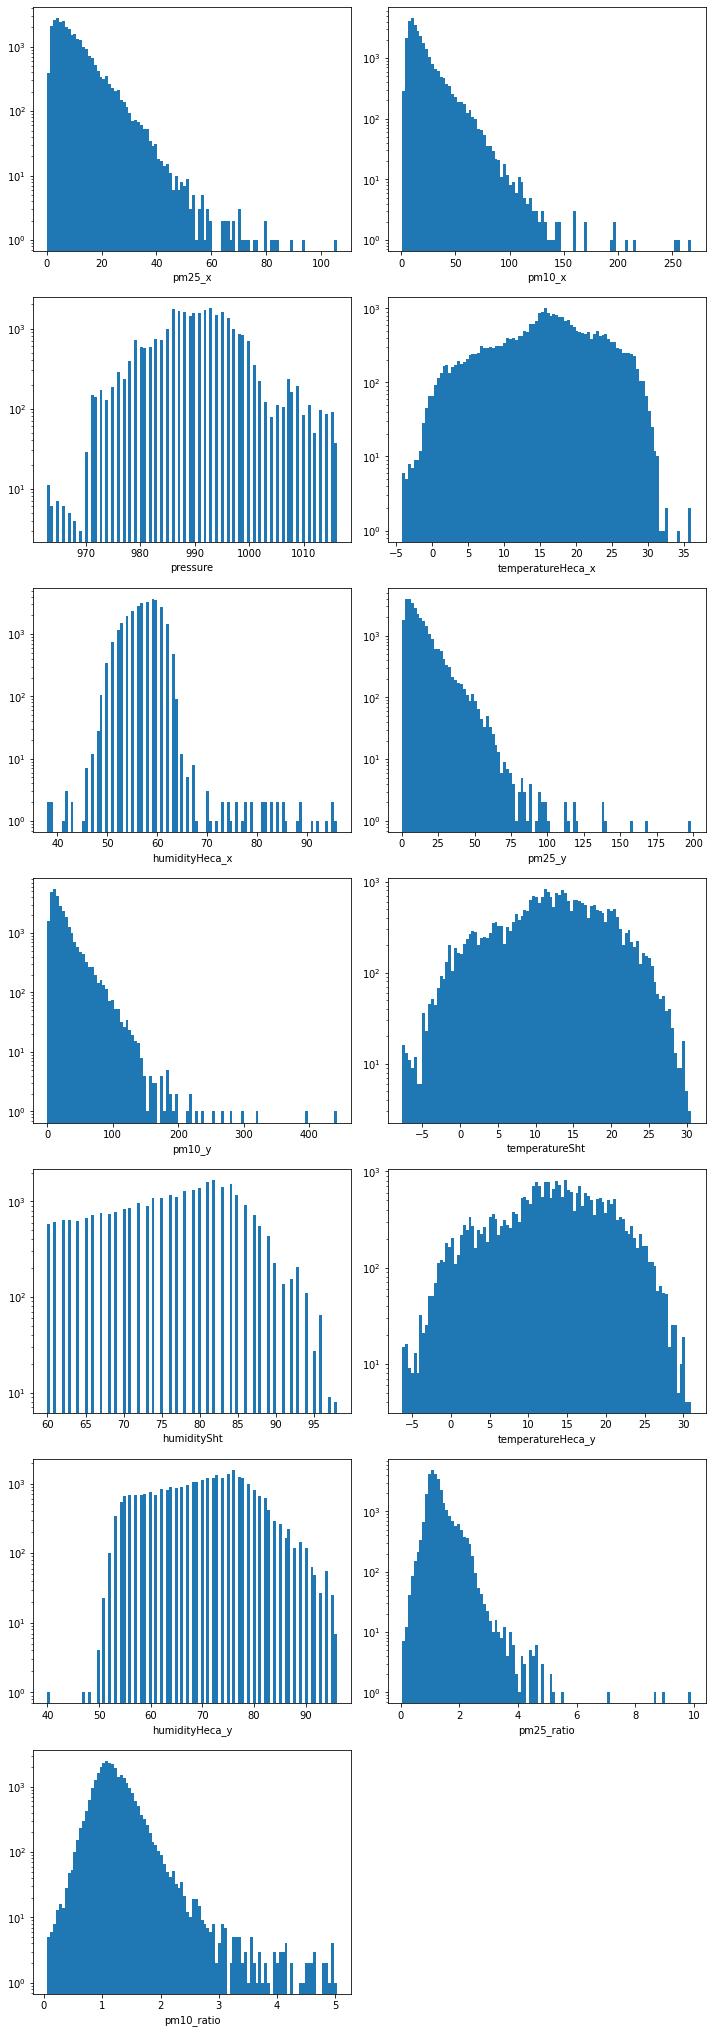

In [8]:
fig = plt.figure(figsize = (10, 40))

for i, key in enumerate(dataset.keys()[2:]):
    plt.subplot(10, 2, i+1)
    plt.hist(dataset[key], bins = 100)
    plt.yscale('log', nonpositive = 'clip')
    plt.xlabel(key)

fig.tight_layout()
plt.show()

In [9]:
dataset[['pm25_ratio', 'pm10_ratio', 'pm25_y', 'pm10_y', 'pressure', 'temperatureSht', 'humiditySht']]

,pm25_ratio,pm10_ratio,pm25_y,pm10_y,pressure,temperatureSht,humiditySht
0,0.73,1.05,13.8,24.4,986,6.1,72
1,0.86,1.31,14.4,27.0,986,5.9,74
2,0.69,1.18,15.1,29.1,986,5.7,75
3,0.83,1.31,18.0,33.7,986,5.7,76
4,0.76,1.22,19.0,36.0,986,5.5,77
...,...,...,...,...,...,...,...
13408,1.93,1.26,8.7,13.0,999,10.9,76
13409,0.75,0.67,5.2,9.0,1000,10.8,77
13410,1.27,0.77,4.7,7.5,1000,10.7,77
13411,1.32,0.99,5.0,8.3,1000,10.6,78


<AxesSubplot:>

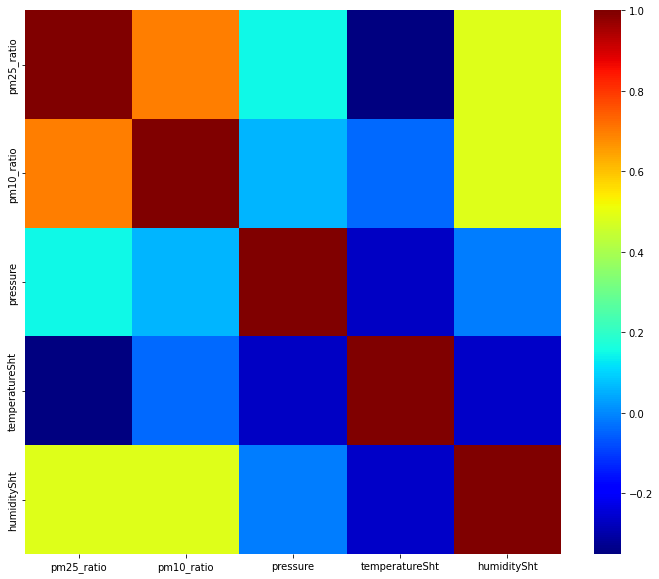

In [10]:
plt.figure(figsize = (12, 10))
sns.heatmap(dataset[['pm25_ratio', 'pm10_ratio', 'pressure', 'temperatureSht', 'humiditySht']].corr(),
            cmap = 'jet')

# Train and test split

Split data for train and test and normalize them

In [14]:
dataset = dataset[['pm25_x', 'pm25_y', 'temperatureSht', 'humiditySht', 'pressure']]

Y = dataset['pm25_x']
X = dataset.drop('pm25_x', axis = 1)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 0)

In [16]:
scaler = preprocessing.StandardScaler().fit(x_train)
y_scaler = max(y_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

y_train = y_train / y_scaler

### Model

In [17]:
model = models.Sequential()

model.add(layers.Dense(64, activation = 'relu', input_shape = (x_train.shape[1],)))
model.add(layers.Dense(80, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))

model.compile(optimizer = Adam(learning_rate=0.0038), loss = 'mae', metrics = ['mae'])

history = model.fit(x_train, y_train, epochs = 10, validation_split = 0.2, batch_size = 256)

Epoch 1/10
75/75 [==============================] - 1s 6ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0166 - val_mae: 0.0166
Epoch 2/10
75/75 [==============================] - 0s 4ms/step - loss: 0.0165 - mae: 0.0165 - val_loss: 0.0157 - val_mae: 0.0157
Epoch 3/10
75/75 [==============================] - 0s 4ms/step - loss: 0.0159 - mae: 0.0159 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 4/10
75/75 [==============================] - 0s 4ms/step - loss: 0.0156 - mae: 0.0156 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 5/10
75/75 [==============================] - 0s 4ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0139 - val_mae: 0.0139
Epoch 6/10
75/75 [==============================] - 0s 4ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 7/10
75/75 [==============================] - 0s 4ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0135 - val_mae: 0.0135
Epoch 8/10
75/75 [==============================] - 0s 4ms/step - loss: 0.0146 - mae: 0.01

In [18]:
history_dict = history.history

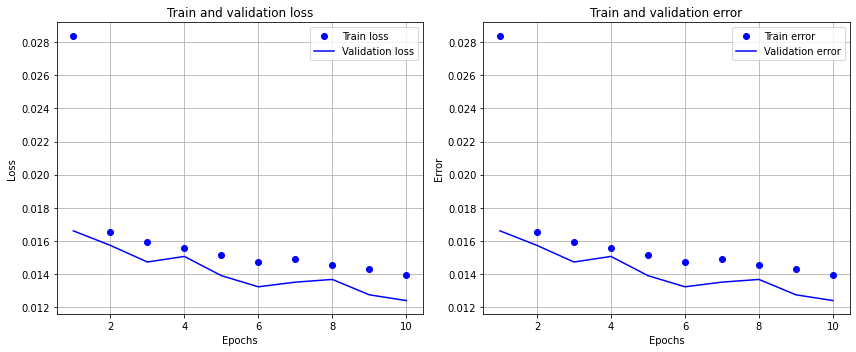

In [19]:
fig = plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Train loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)
mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs, mae, 'bo', label = 'Train error')
plt.plot(epochs, val_mae, 'b', label = 'Validation error')
plt.title('Train and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

fig.tight_layout()
plt.show()

# Results

In [20]:
test_loss, test_err = model.evaluate(x_test, y_test)

186/186 [==============================] - 0s 2ms/step - loss: 9.6813 - mae: 9.6813


In [21]:
print('test_err:', test_err)

test_err: 9.681283950805664


In [22]:
y_pred = model.predict(x_test).reshape(-1,) * y_scaler

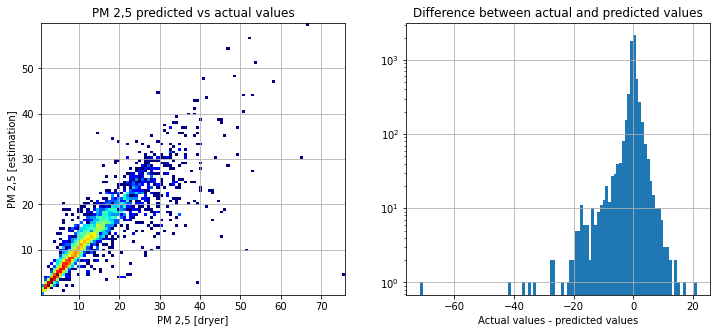

In [23]:
fig = plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.hist2d(y_test, y_pred, bins= 100, cmap = 'jet', norm = matplotlib.colors.LogNorm())
plt.xlabel('PM 2,5 [dryer]')
plt.ylabel('PM 2,5 [estimation]')
plt.title('PM 2,5 predicted vs actual values')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(y_pred - y_test, bins = 100)
plt.yscale('log')
plt.xlabel('Actual values - predicted values')
plt.title('Difference between actual and predicted values')
plt.grid(True)
plt.show()

fig.tight_layout()
plt.show()

In [24]:
r2 = r2_score(y_test, y_pred) * 100
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('R2: ', r2)
print('MSE: ', mse)
print('MAE: ', mae)

R2:  84.52924225636403
MSE:  9.140201982583953
MAE:  1.3464963500724723
